In [72]:
deps <- c("ISLR", "Metrics", "tidyr", "microbenchmark", "dplyr", "gridExtra", "readxl", "cvTools", "leaps", "assertthat", "assertr", "testthat", "lubridate", "ggplot2", "stringr", "scales", "viridis")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}

options(scipen=999)
set.seed(42)

df <- read.csv("../data/data.csv", header = TRUE, sep = ",")

df$aspects <- gsub("\\[|\\]|\\'", "", df$aspects)
df$aspects <- gsub("n't", "", df$aspects)
df <- df[!is.na(df$aspects) & df$aspects != "" & df$category != "unknown",]
df$category[is.na(df$category)] <- "unknown"

for (i in 1:ncol(df)) {
    cat(colnames(df)[i], "\n")
    cat("\ttype: ", class(df[,i]), "\n")
    cat("\tmissing: ", sum(is.na(df[,i])), "\n")
    cat("\tunique: ", length(unique(df[,i])), "\n")
    topfreq <- sort(table(df[,i]), decreasing = TRUE)[1:5]
    cat("\ttop 5 values:", names(topfreq), "\n")
}

rating 
	type:  numeric 
	missing:  0 
	unique:  5 
	top 5 values: 5 4 3 1 2 
title 
	type:  character 
	missing:  0 
	unique:  1818 
	top 5 values: Five Stars Great Nice Four Stars Beautiful 
text 
	type:  character 
	missing:  0 
	unique:  1989 
	top 5 values: I hate to &#34;review&#34; movies cause it's subjective... so honestly, I just like this movie.  If you like the actors in this film, you'll probably like this movie. Love it! OK "  The first thing which impressed me was the ease of installation. Also, it was the first screen protector I’ve had in a while where there was not multiple air bubbles left after I installed it. The clarity of the screen protector and the touch sensitivity is excellent. I am looking forward to see how well it resists fingerprints. "Into the West" is an underrated jewel of Irish filmmaking that follows a rather unconventional storyline: a down-and-out father, Papa Reilly, (Gabriel Byrne), leads a miserable existence in a Dublin slum along with his two 

# (RQ1) Are reviews for some categories of product on Amazon overall more positive than for other categories?

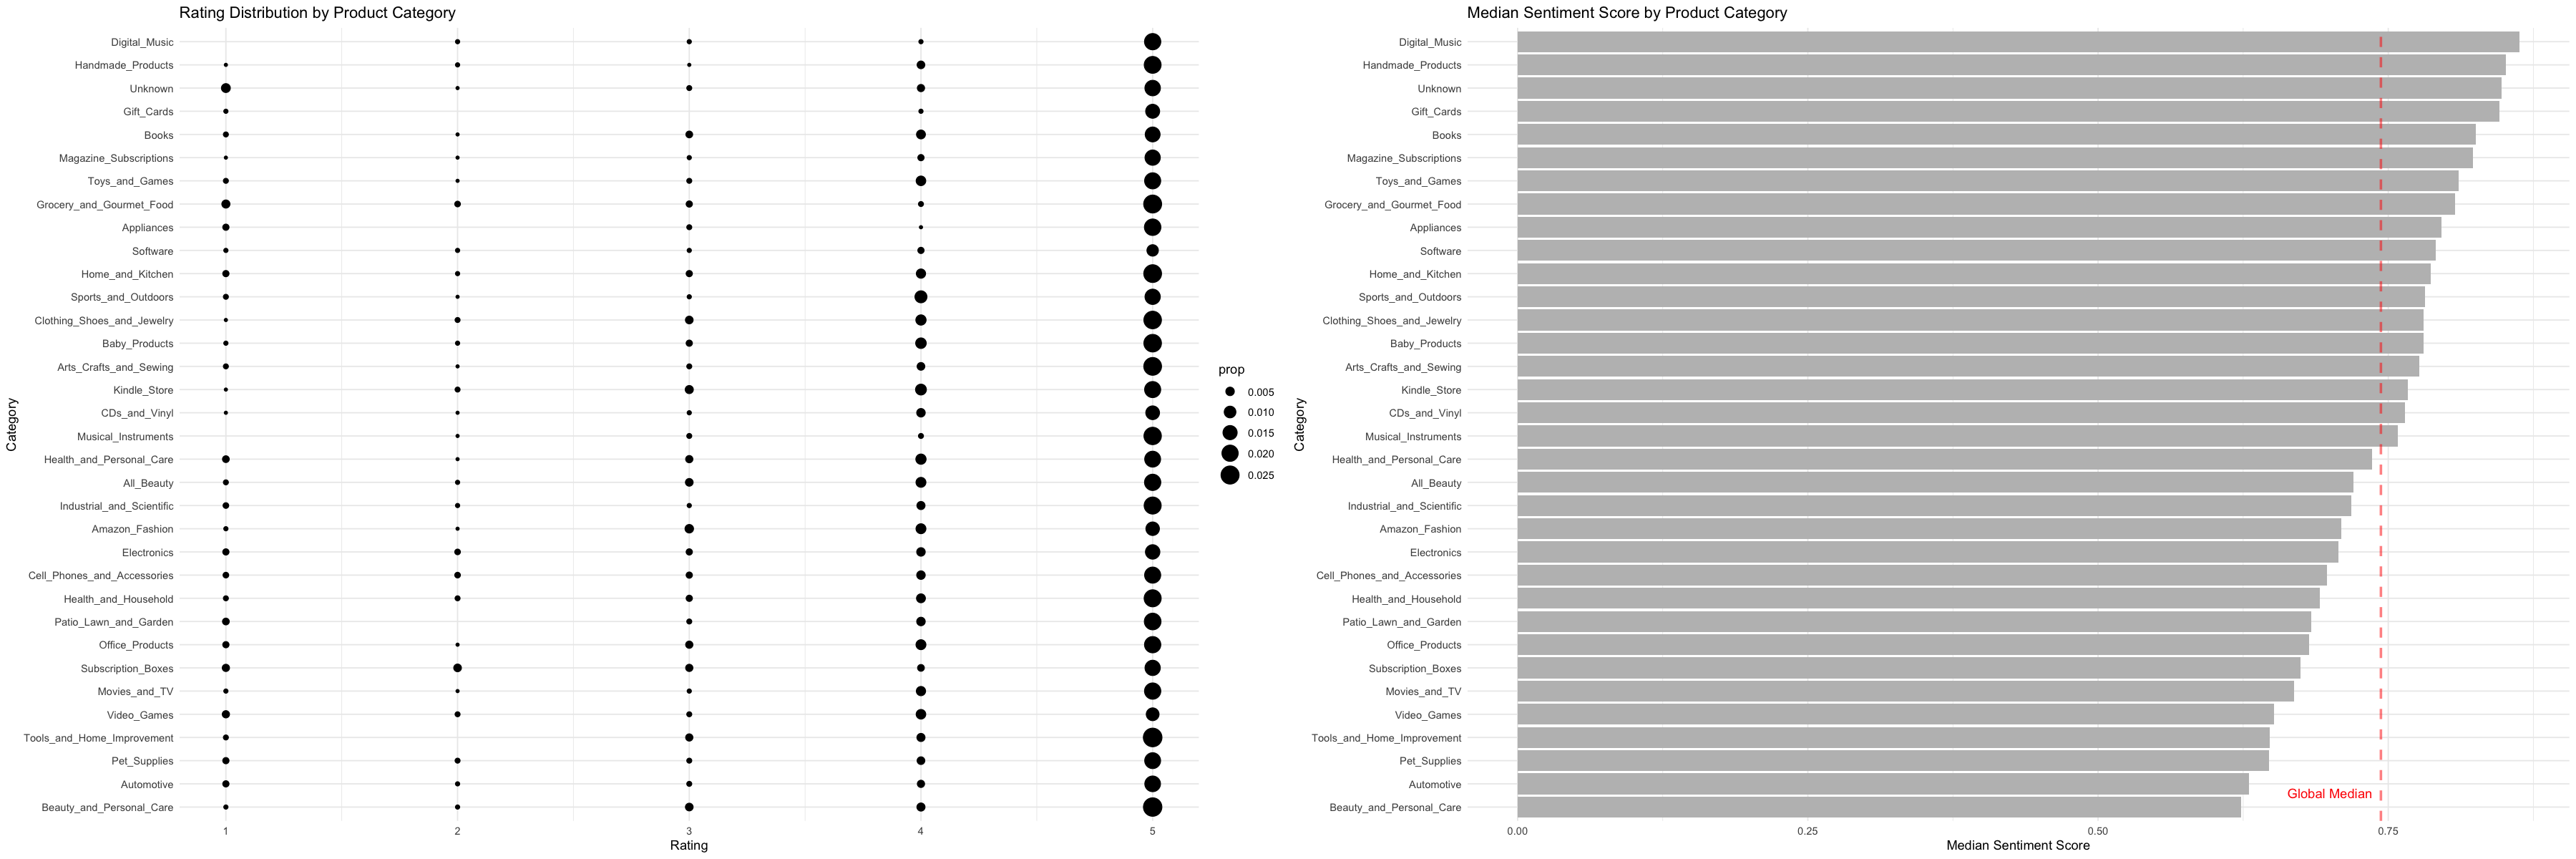

In [73]:
options(repr.plot.width=30, repr.plot.height=10)

median_sentiment <- aggregate(df$sentiment_score, by = list(Category = df$category), FUN = median)
ordered_categories <- median_sentiment$Category[order(median_sentiment$x)]

p1 <- ggplot(df, aes(x = factor(category, levels = ordered_categories), y = rating)) +
    geom_count(aes(size = after_stat(prop), group = 1)) +
    scale_size_area(max_size = 7) +
    coord_flip() +
    labs(title = "Rating Distribution by Product Category", x = "Category", y = "Rating") +
    theme(axis.text.y = element_text(size = 8)) +
    theme_minimal()

global_median <- median(df$sentiment_score, na.rm = TRUE)

p2 <- ggplot(median_sentiment, aes(x = factor(Category, levels = ordered_categories), y = x)) + 
    geom_bar(stat = 'identity', fill = 'gray') + 
    geom_hline(yintercept = global_median, color = "red", linetype = "dashed", size = 1, alpha = 0.5) +
    annotate("text", x = 1, y = global_median, label = "Global Median", vjust = -1, hjust = 1.1, color = "red") +
    coord_flip() +
    labs(title = 'Median Sentiment Score by Product Category', x = 'Category', y = 'Median Sentiment Score') +       
    theme(axis.text.y = element_text(size = 8)) +
    theme_minimal()

grid.arrange(p1, p2, ncol = 2)

# (RQ2) Are reviews more subjective for some classes of products than for others?

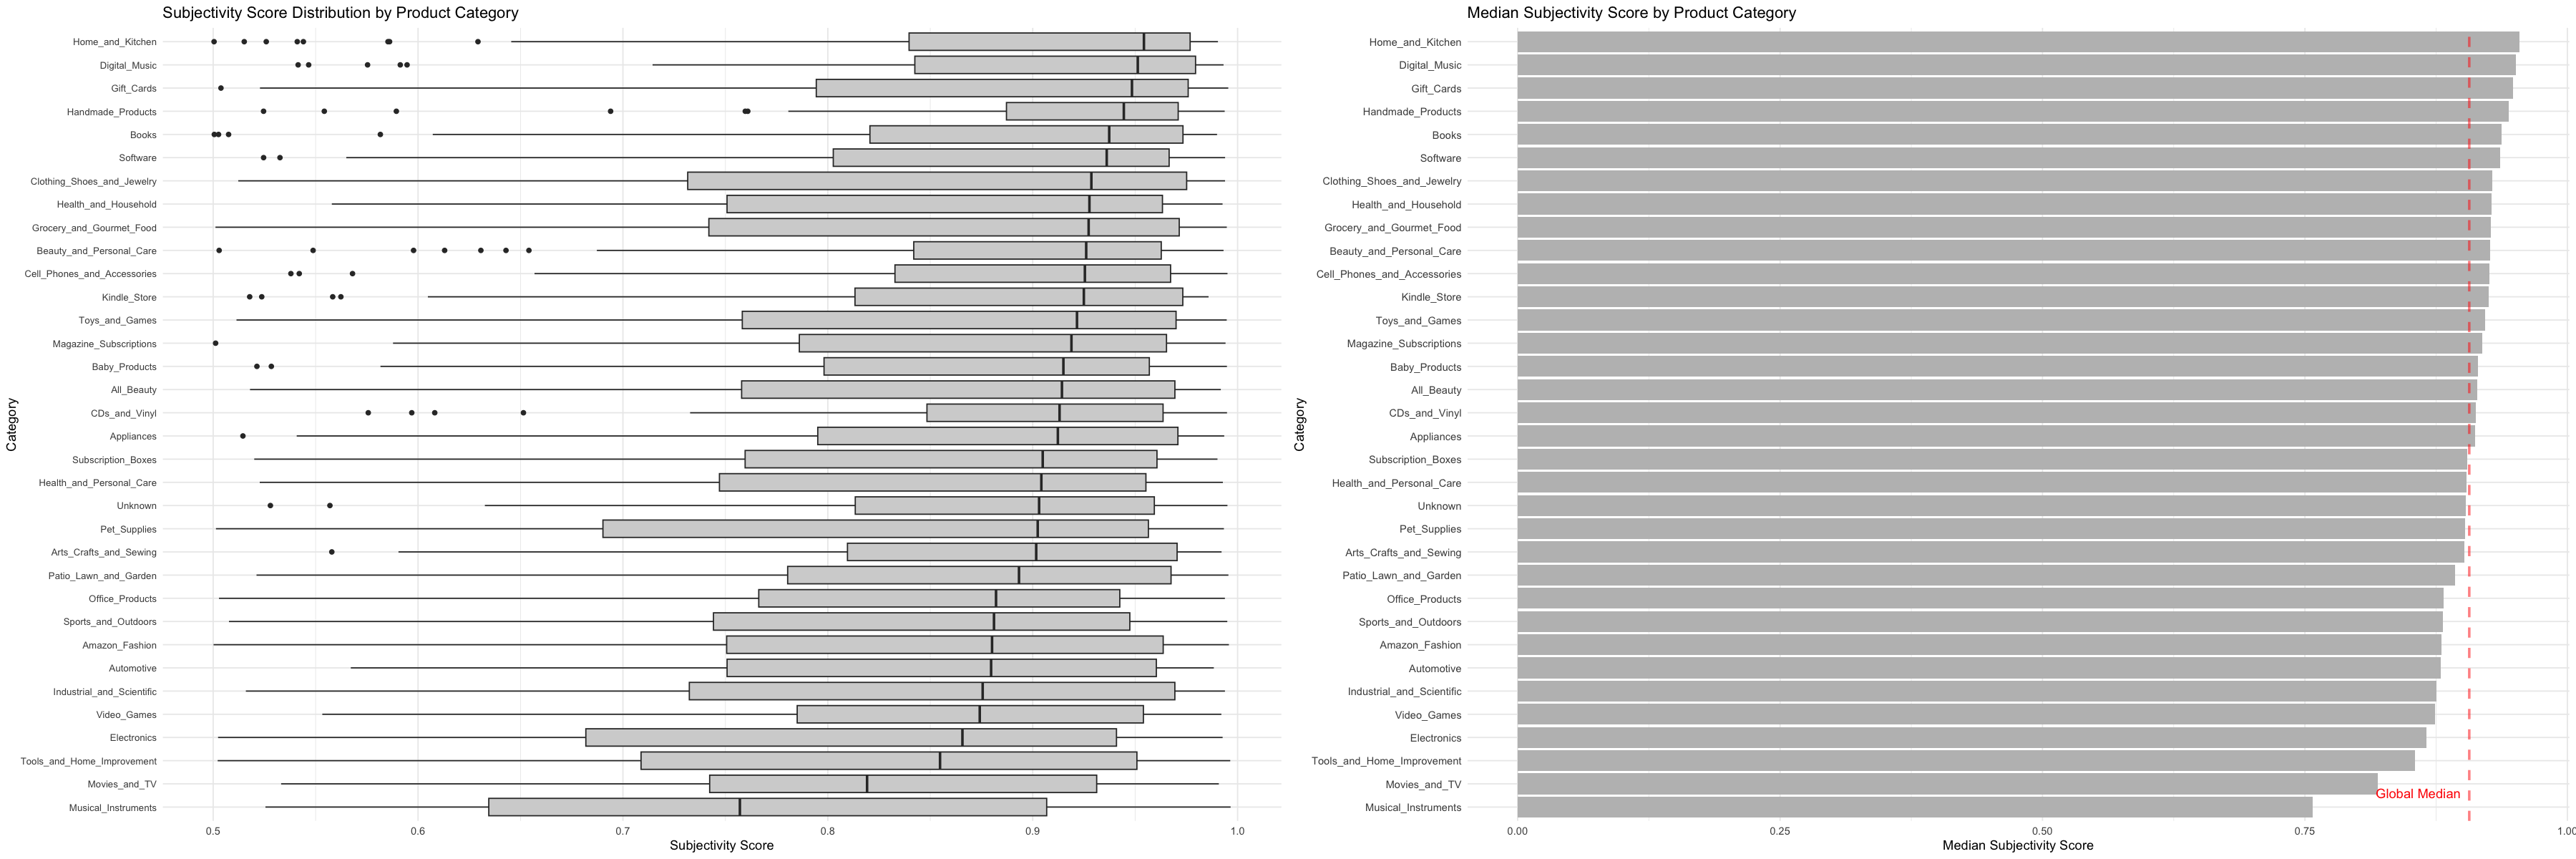

In [74]:
options(repr.plot.width=30, repr.plot.height=10)

p1 <- ggplot(df, aes(x = reorder(category, subjectivity_score, median), y = subjectivity_score)) +
    geom_boxplot(fill = "lightgray") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Subjectivity Score Distribution by Product Category", x = "Category", y = "Subjectivity Score") +
    theme(axis.text.y = element_text(size = 8))

median_subjectivity <- aggregate(df$subjectivity_score, by = list(Category = df$category), FUN = median)
ordered_categories_subjectivity <- median_subjectivity$Category[order(median_subjectivity$x)]
global_median_subjectivity <- median(df$subjectivity_score, na.rm = TRUE)

p2 <- ggplot(median_subjectivity, aes(x = factor(Category, levels = ordered_categories_subjectivity), y = x)) + 
    geom_bar(stat = 'identity', fill = 'gray') + 
    geom_hline(yintercept = global_median_subjectivity, color = "red", linetype = "dashed", size = 1, alpha = 0.5) +
    annotate("text", x = 1, y = global_median_subjectivity, label = "Global Median", vjust = -1, hjust = 1.1, color = "red") +
    coord_flip() +
    labs(title = 'Median Subjectivity Score by Product Category', x = 'Category', y = 'Median Subjectivity Score') +       
    theme(axis.text.y = element_text(size = 8)) +
    theme_minimal()

grid.arrange(p1, p2, ncol = 2)

# (RQ3) Which aspects of different classes of products are the most important in the reviews?


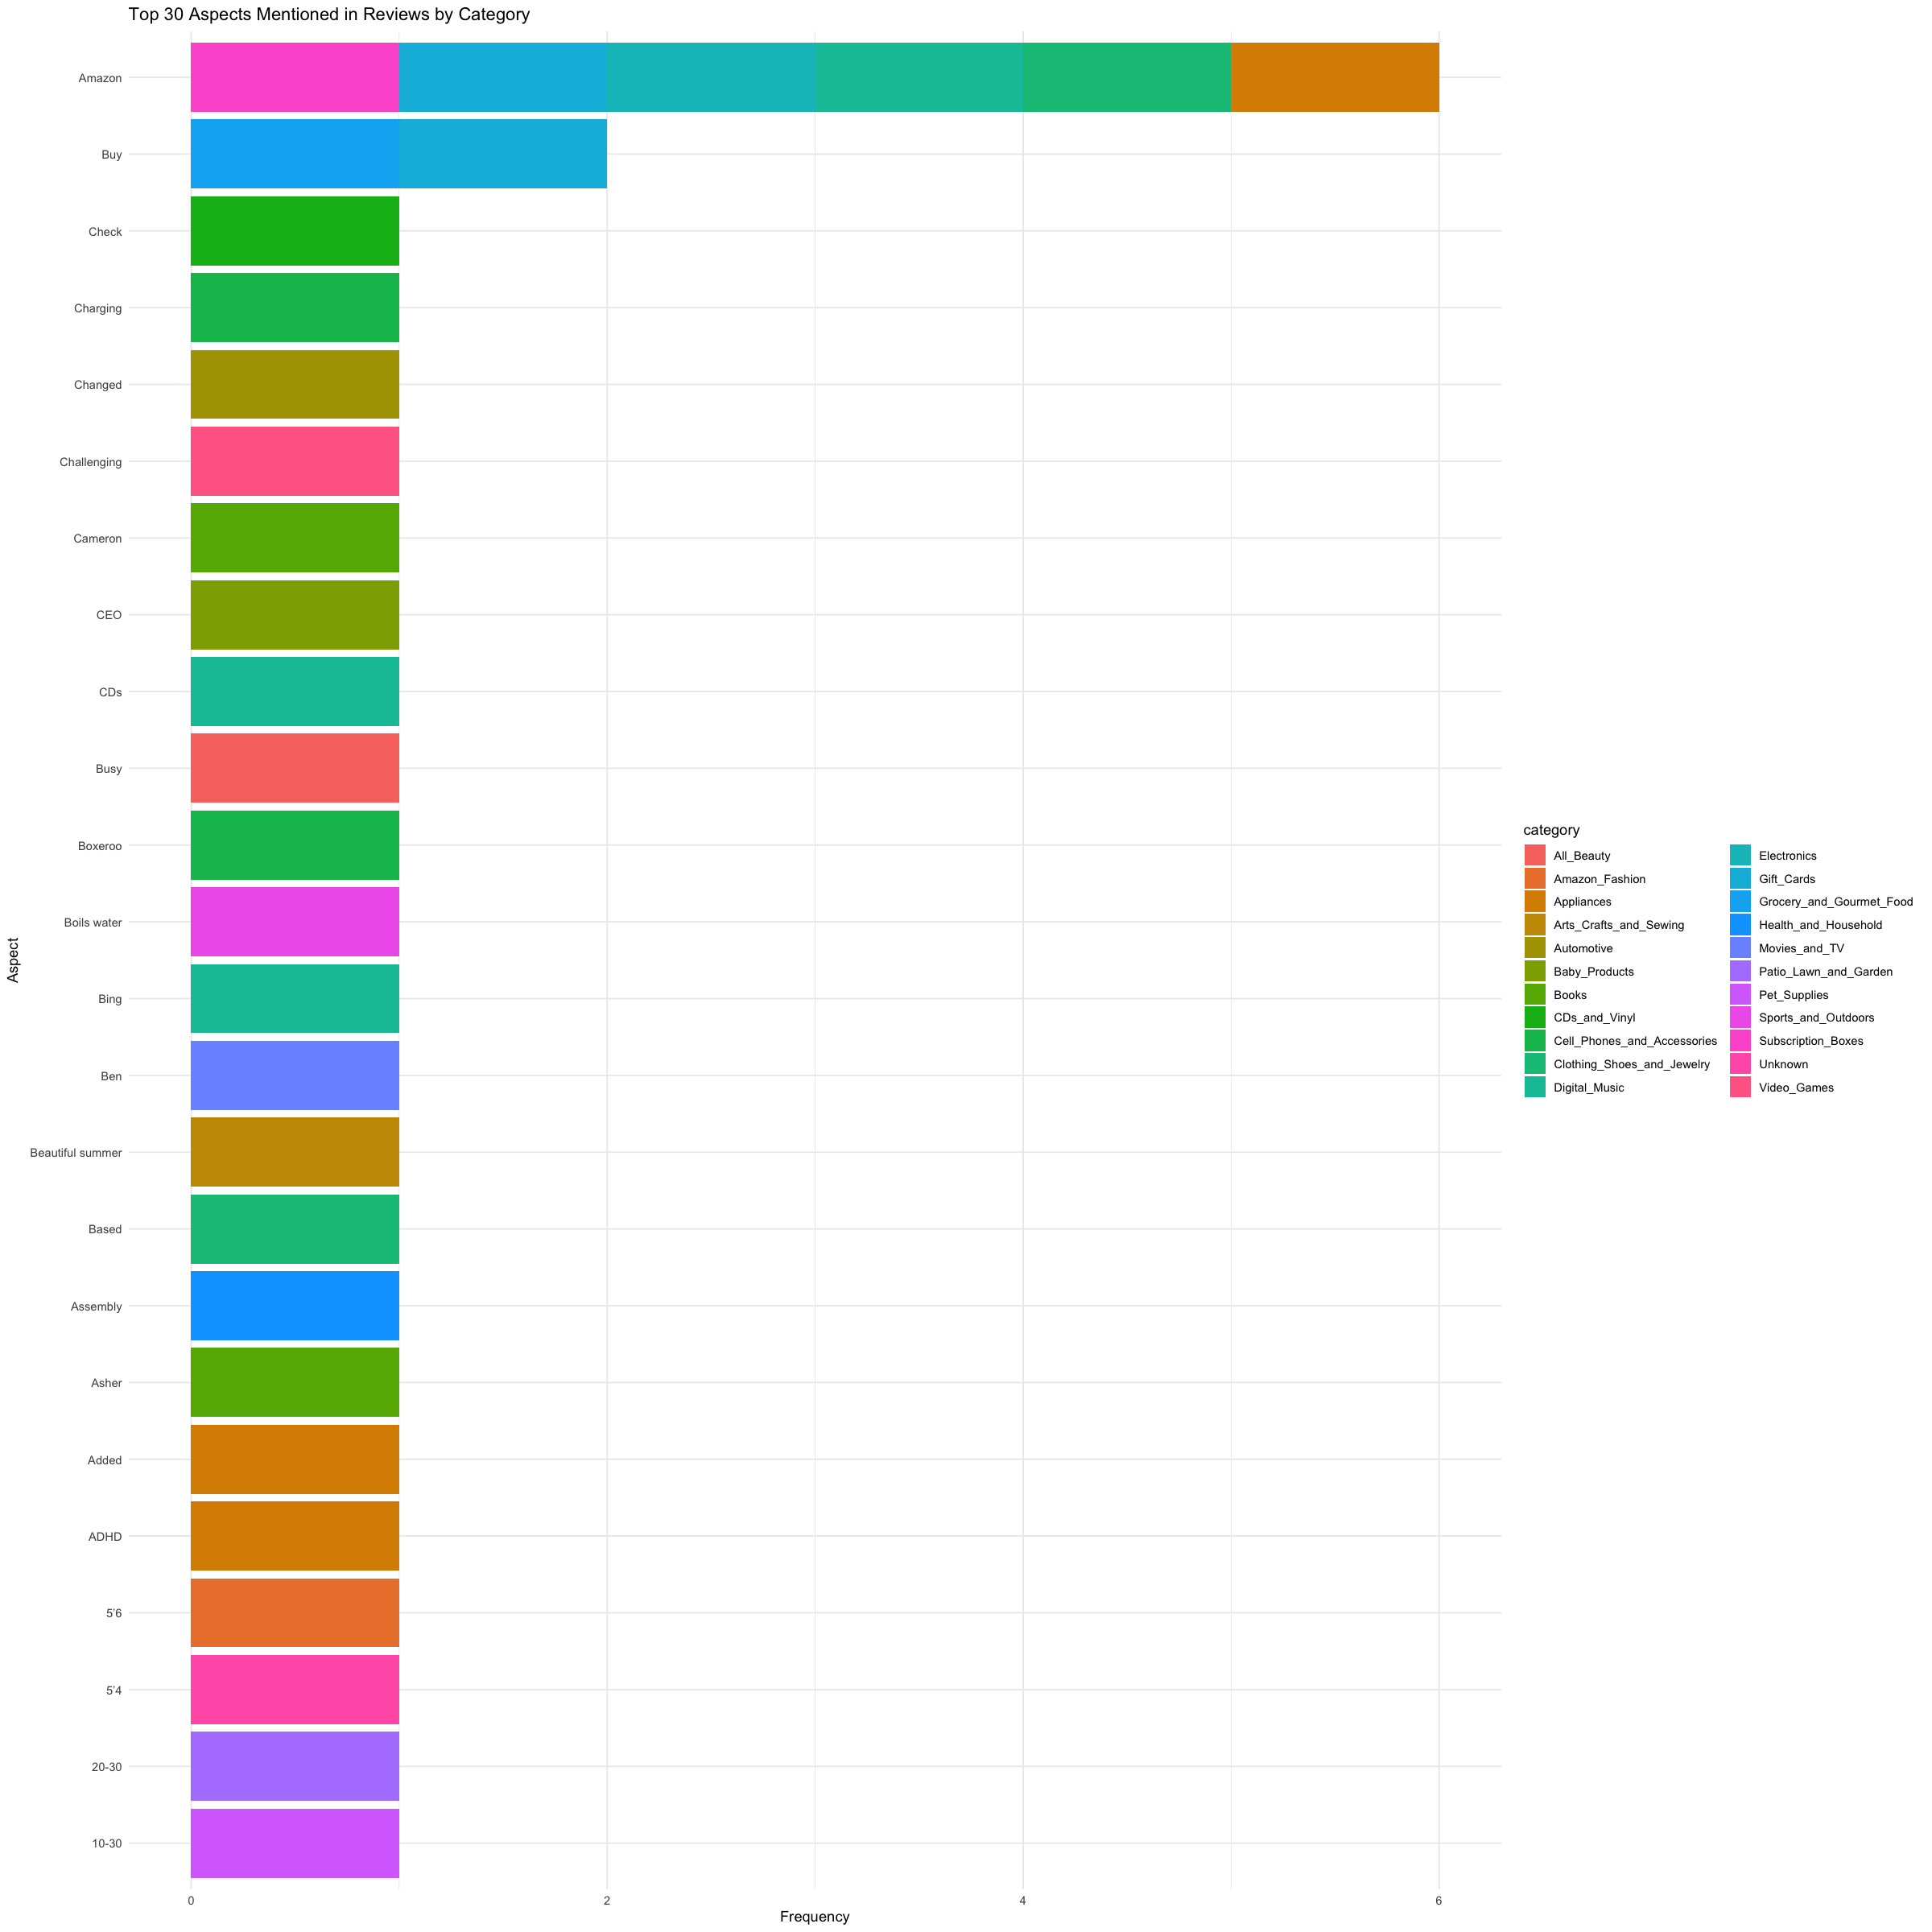

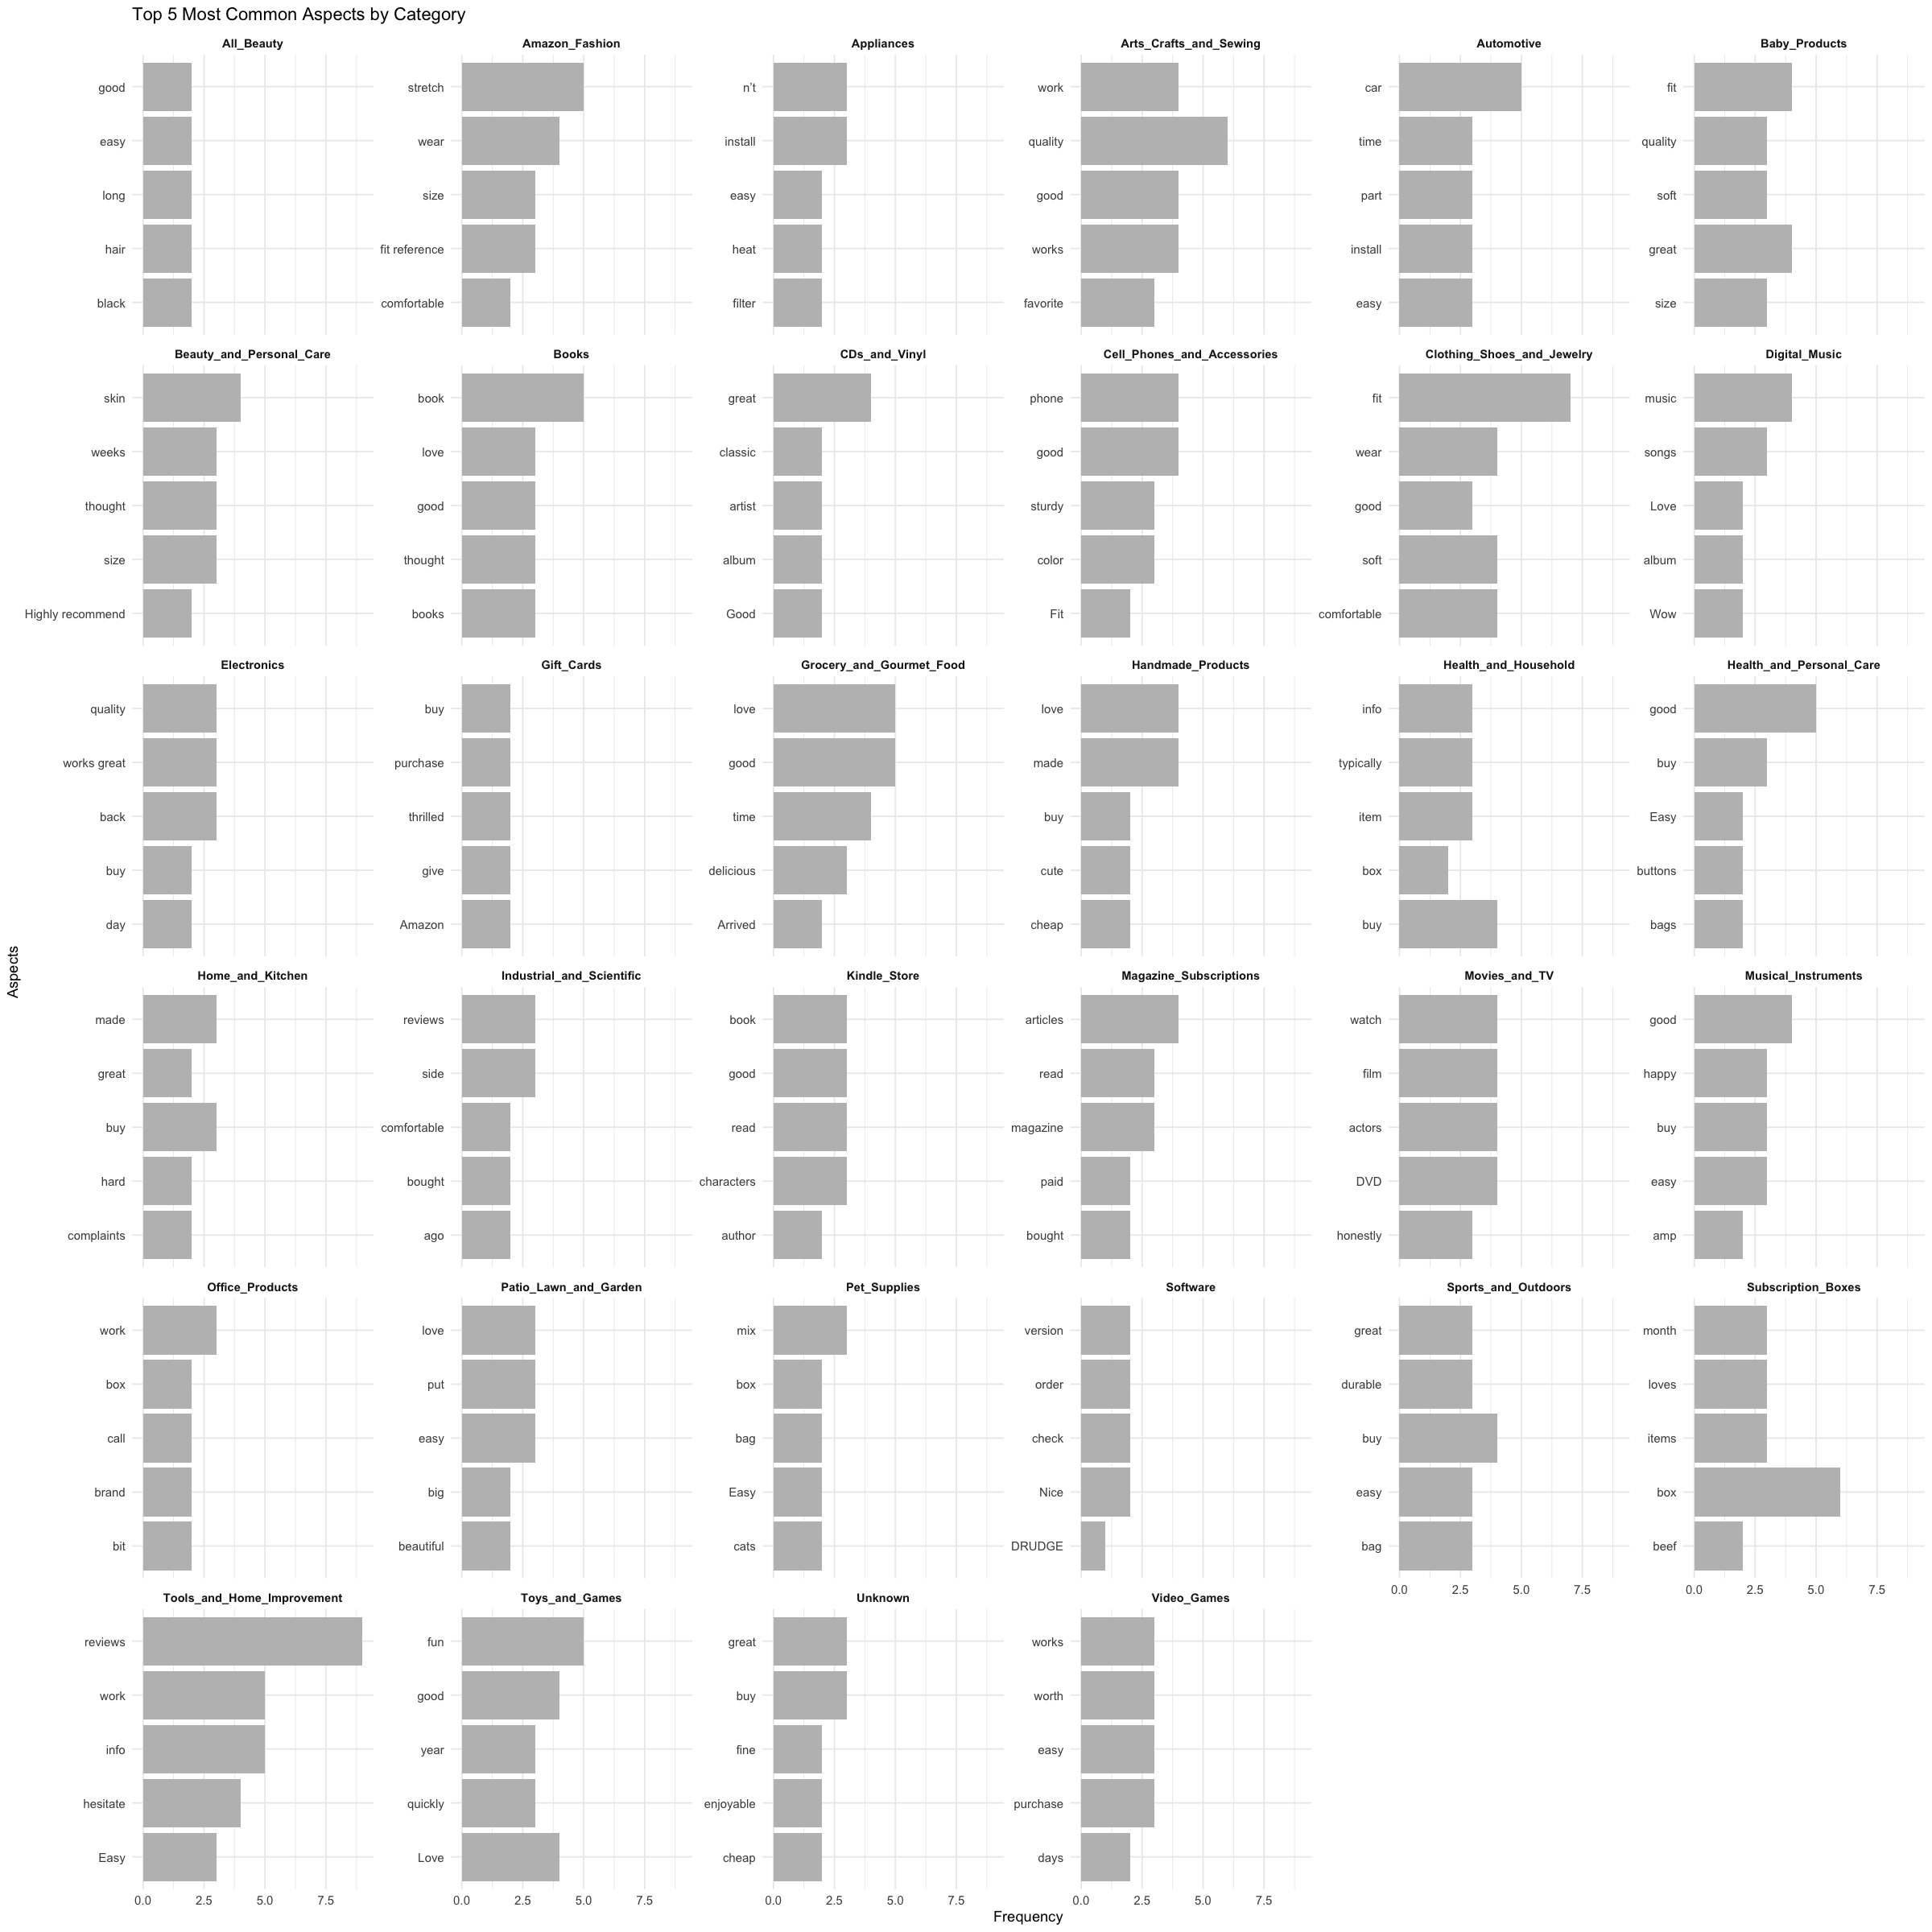

In [75]:
options(repr.plot.width=20, repr.plot.height=20)

total_counts <- df %>%
    separate_rows(aspects, sep = ",") %>%
    filter(aspects != "") %>%
    group_by(aspects) %>%
    summarise(total = n())
aspects_df <- df %>%
    separate_rows(aspects, sep = ",") %>%
    filter(aspects != "") %>%
    group_by(aspects, category) %>%
    summarise(count = n(), .groups = 'drop') %>%
    left_join(total_counts, by = "aspects")
ggplot(head(aspects_df, 30), aes(x = reorder(aspects, total), y = count, fill = category)) +
    geom_bar(stat = "identity") +
    coord_flip() +
    theme_minimal() +
    labs(title = "Top 30 Aspects Mentioned in Reviews by Category", x = "Aspect", y = "Frequency")

aspects_df <- df %>%
    separate_rows(aspects, sep = ", ") %>%
    count(category, aspects, sort = TRUE) %>%
    group_by(category) %>%
    slice_head(n = 5) %>%
    filter(!is.na(aspects))
ggplot(aspects_df, aes(x = reorder(aspects, n), y = n)) +
    geom_col(fill = "gray") +
    facet_wrap(~category, scales = "free_y") +
    coord_flip() +
    theme_minimal() +
    labs(x = "Aspects", y = "Frequency", title = "Top 5 Most Common Aspects by Category") +
    theme(strip.text = element_text(face = "bold"), axis.text = element_text(size = 9))

# (RQ4) Can one predict the star rating from the review text?



|Actual   |Predicted | Count|
|:--------|:---------|-----:|
|Positive |Positive  |    16|
|Positive |Negative  |    26|
|Negative |Positive  |     5|
|Negative |Negative  |    68|

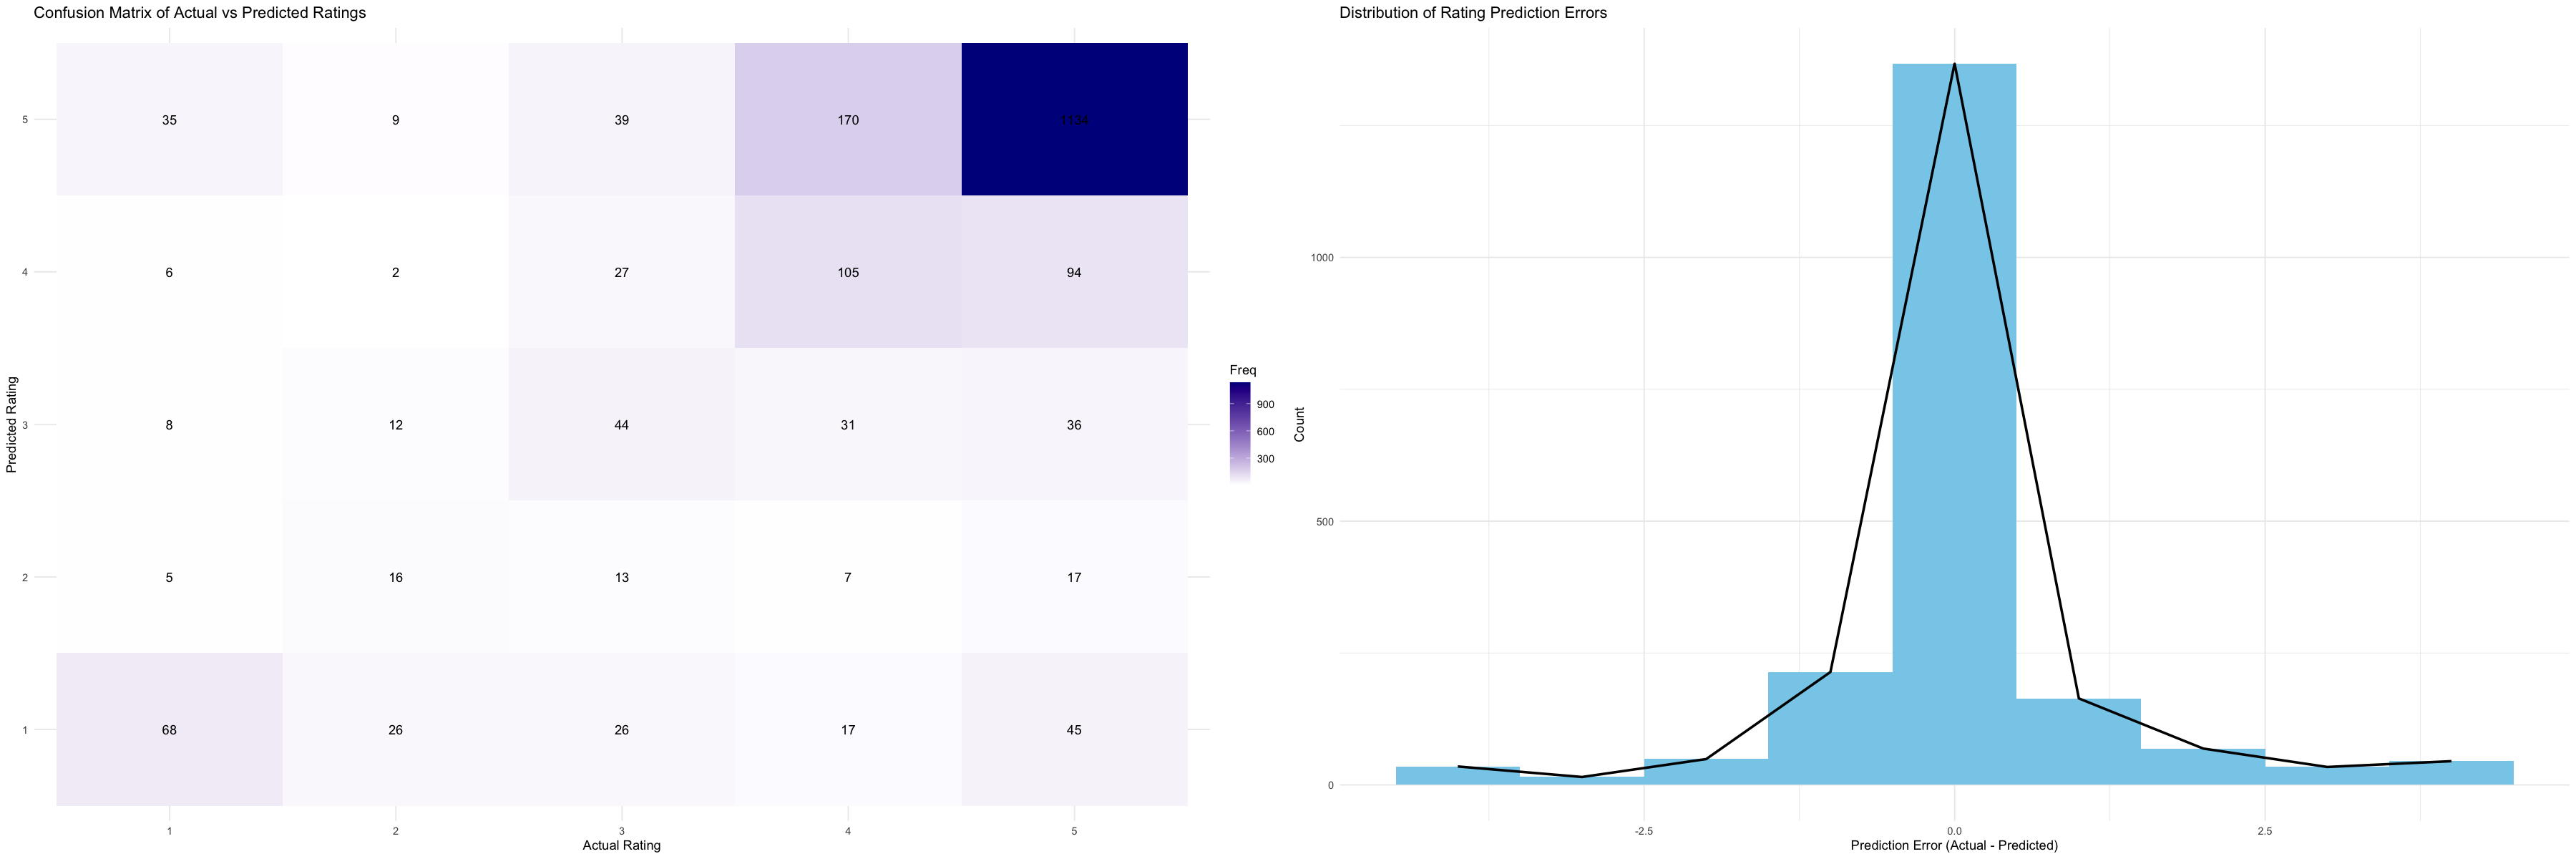

In [76]:
options(repr.plot.width=5, repr.plot.height=5)

# looks pretty but kind of confusing
# ggplot(df, aes(x = rating, y = predicted_rating)) +
#     geom_jitter(alpha = 0.1) +
#     geom_abline(intercept = 0, slope = 1, color = "red", linetype = "dashed") +
#     labs(x = "Actual Rating", y = "Predicted Rating", title = "Actual vs Predicted Ratings") +
#     theme_minimal()

# ggplot(df, aes(x = factor(rating), y = factor(predicted_rating))) +
#     geom_count(aes(size = after_stat(prop), group = 1)) +
#     scale_size_area(max_size = 20) +
#     theme_minimal() +
#     labs(x = "Actual Rating", y = "Predicted Rating", title = "Actual vs Predicted Ratings", size = "Proportion")


# df %>%
#     group_by(category) %>%
#     summarize(accuracy = mean(predicted_rating == rating)) %>%
#     ggplot(aes(x = reorder(category, accuracy), y = accuracy)) +
#     geom_col() +
#     coord_flip() +
#     theme_minimal() +
#     labs(x = "Category", y = "Prediction Accuracy", title = "Rating Prediction Accuracy by Category")

options(repr.plot.width=30, repr.plot.height=10)

confusion_matrix <- table(df$rating, df$predicted_rating)
p1 <- ggplot(as.data.frame(confusion_matrix), aes(x = Var1, y = Var2, fill = Freq)) +
    geom_tile() +
    scale_fill_gradient(low = "white", high = "darkblue") +
    geom_text(aes(label = Freq), color = "black") +
    labs(x = "Actual Rating", y = "Predicted Rating", title = "Confusion Matrix of Actual vs Predicted Ratings") +
    theme_minimal()

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
p2 <- ggplot(df, aes(x = rating - predicted_rating)) +
    geom_histogram(binwidth = 1, fill = "skyblue") +
    geom_line(stat = "count", aes(group = 1), color = "black", size = 1) +
    labs(x = "Prediction Error (Actual - Predicted)", y = "Count", title = "Distribution of Rating Prediction Errors") +
    theme_minimal()

grid.arrange(p1, p2, ncol = 2)

knitr::kable(data.frame(
    "Actual" = c("Positive", "Positive", "Negative", "Negative"),
    "Predicted" = c("Positive", "Negative", "Positive", "Negative"),
    "Count" = c(confusion_matrix[2,2], confusion_matrix[2,1], confusion_matrix[1,2], confusion_matrix[1,1])
), row.names = FALSE)


# data exploration

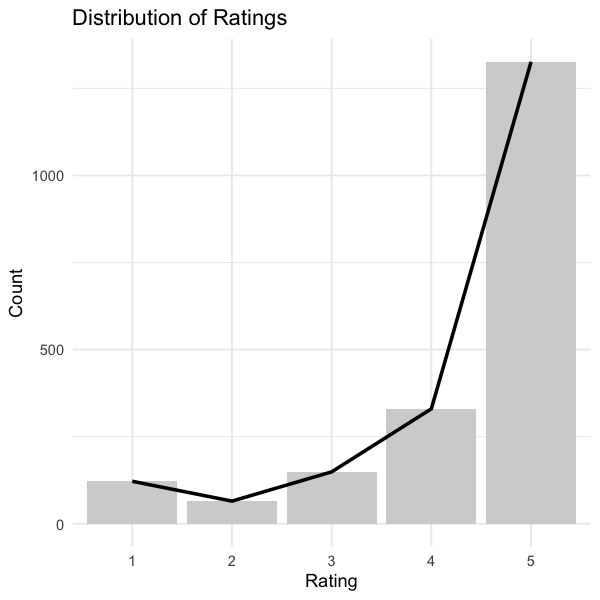

`geom_smooth()` using formula = 'y ~ x'


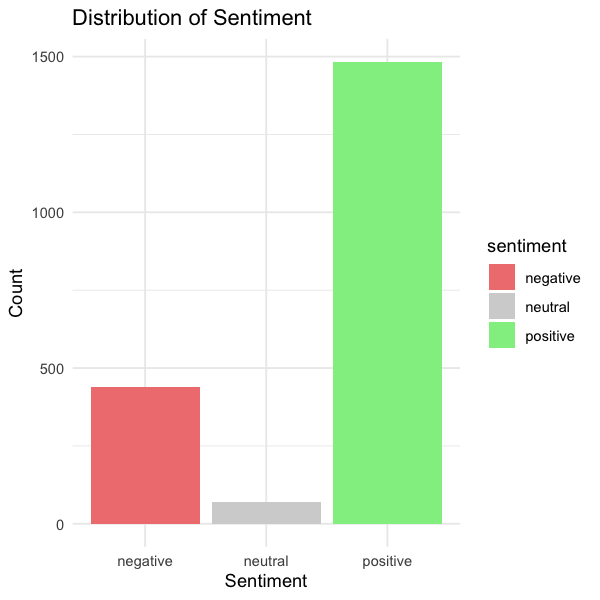

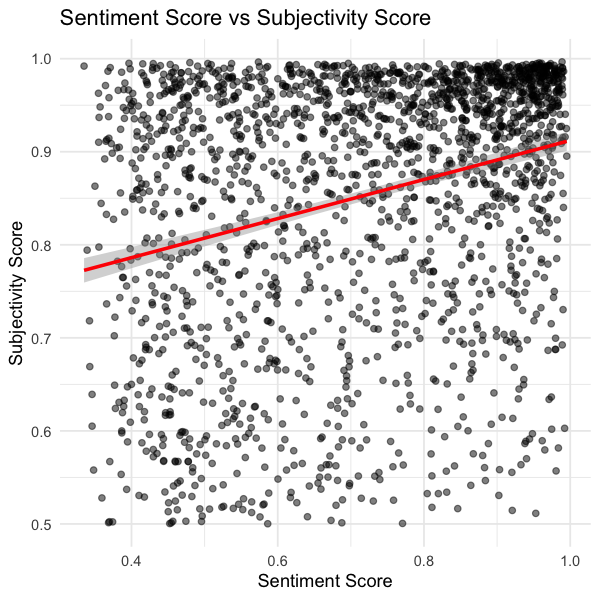

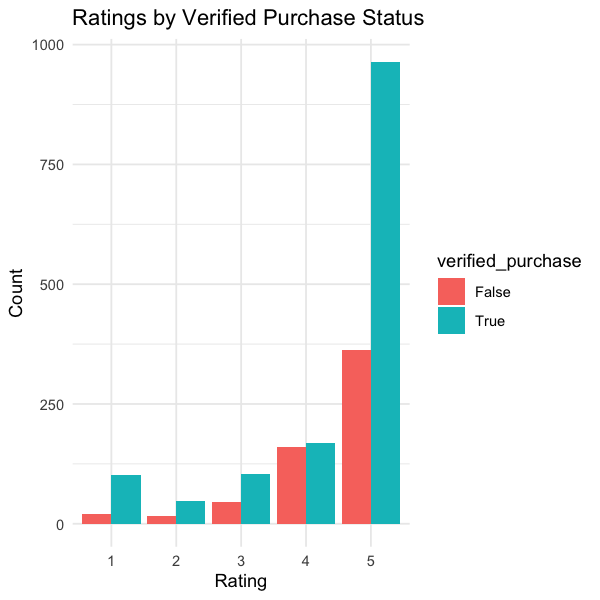

`geom_smooth()` using formula = 'y ~ x'


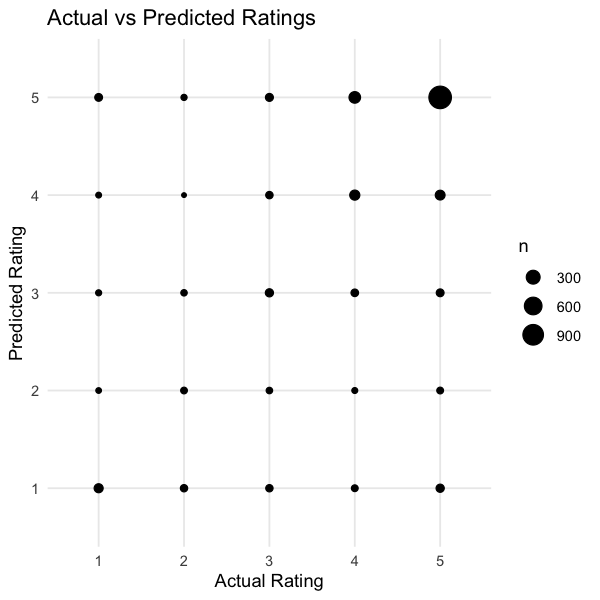

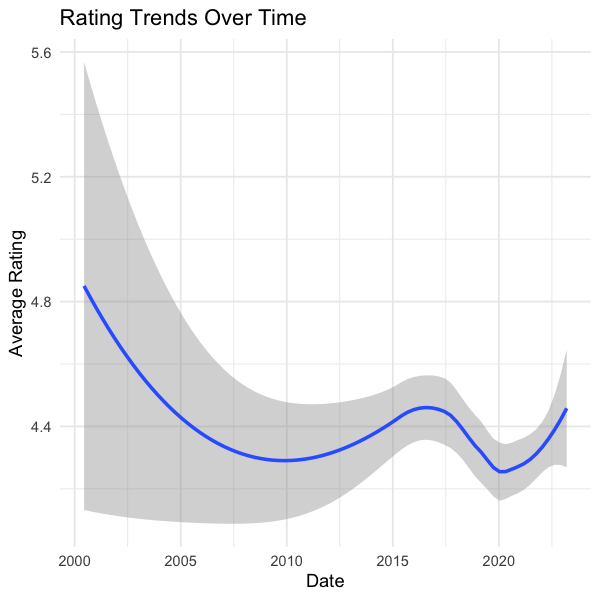

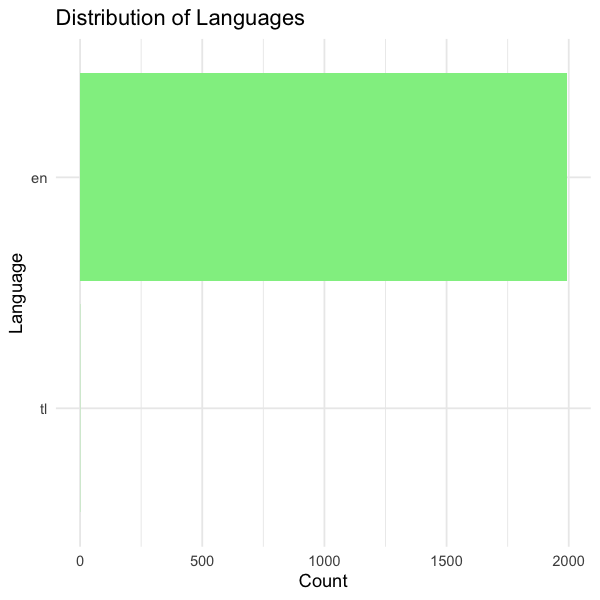

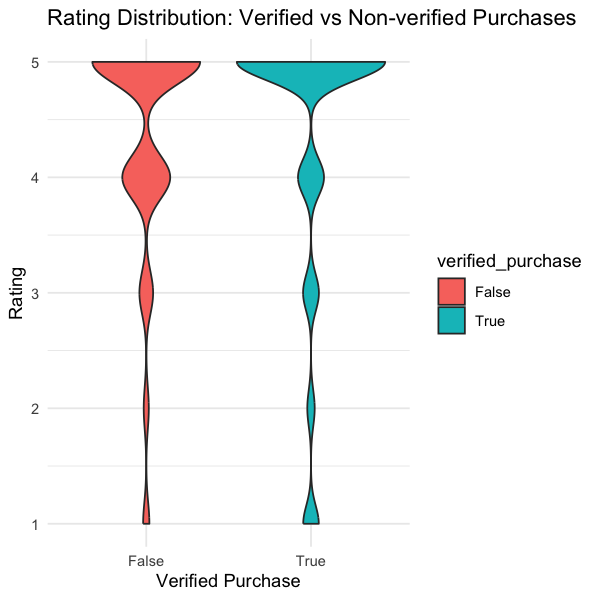

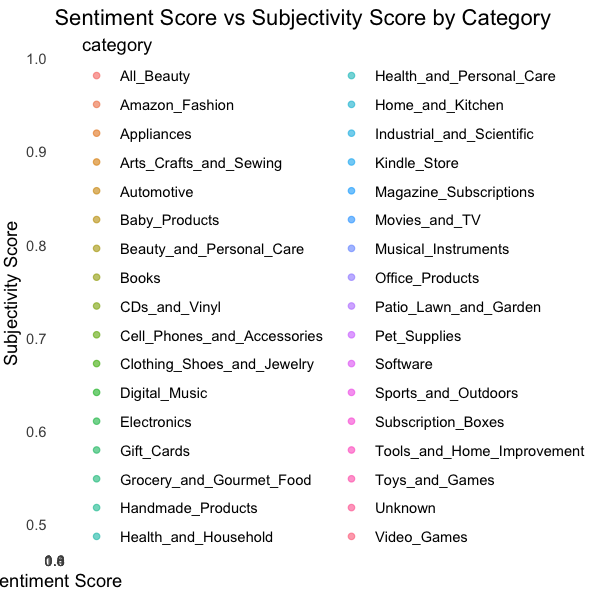

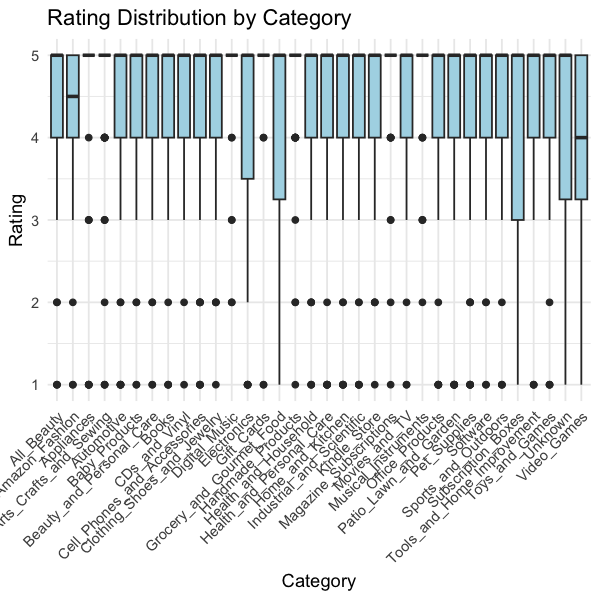

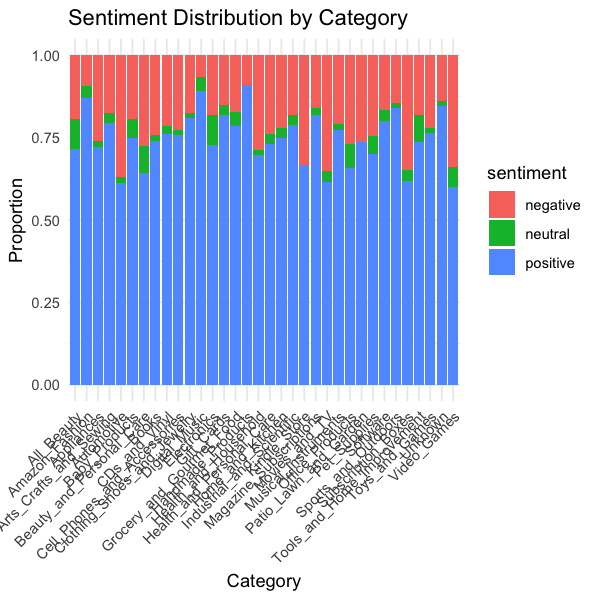

`summarise()` has grouped output by 'category'. You can override using the
`.groups` argument.


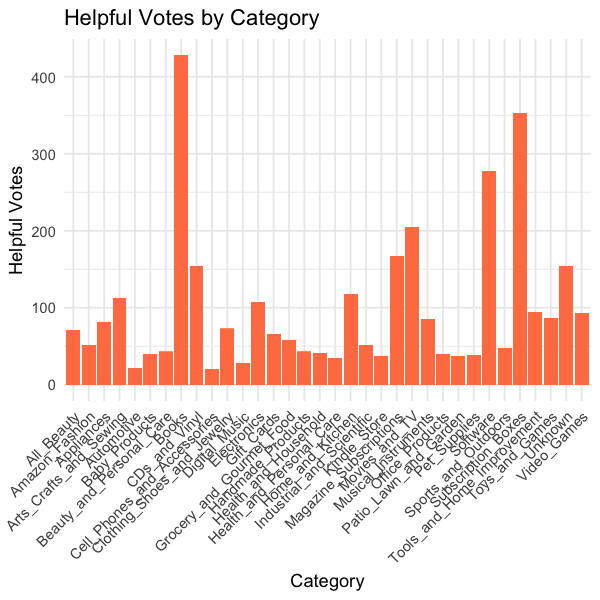

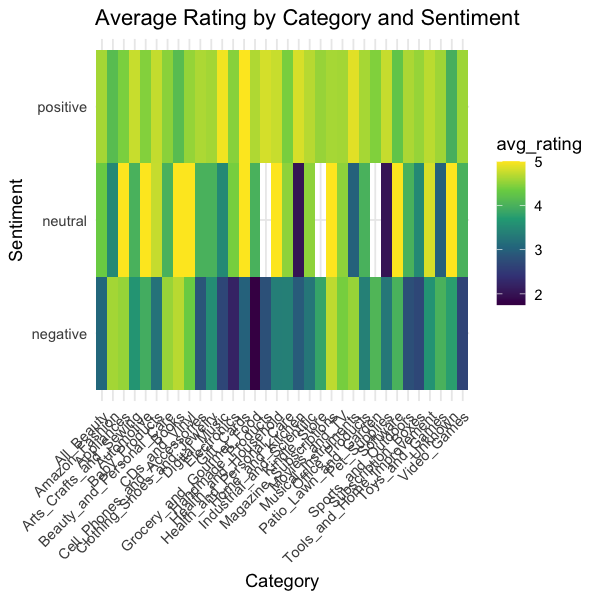

In [77]:
options(repr.plot.width=5, repr.plot.height=5)

ggplot(df, aes(x = factor(rating))) +
    geom_bar(fill = "lightgray") +
    geom_line(stat = "count", aes(group = 1), color = "black", size = 1) +
    labs(title = "Distribution of Ratings", x = "Rating", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = sentiment, fill = sentiment)) +
    geom_bar() +
    scale_fill_manual(values = c("positive" = "lightgreen", "negative" = "lightcoral", "neutral" = "lightgray")) +
    labs(title = "Distribution of Sentiment", x = "Sentiment", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = sentiment_score, y = subjectivity_score)) +
    geom_point(alpha = 0.5) +
    geom_smooth(method = "lm", color = "red") +
    labs(title = "Sentiment Score vs Subjectivity Score", x = "Sentiment Score", y = "Subjectivity Score") +
    theme_minimal()

ggplot(df, aes(x = factor(rating), fill = verified_purchase)) +
    geom_bar(position = "dodge") +
    labs(title = "Ratings by Verified Purchase Status", x = "Rating", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = factor(rating), y = factor(predicted_rating))) +
    geom_count() +
    labs(title = "Actual vs Predicted Ratings", x = "Actual Rating", y = "Predicted Rating") +
    theme_minimal()

df %>%
    mutate(timestamp = as.Date(timestamp)) %>%
    ggplot(aes(x = timestamp, y = rating)) +
    geom_smooth(method = "loess") +
    labs(title = "Rating Trends Over Time", x = "Date", y = "Average Rating") +
    theme_minimal()

df %>%
    count(language) %>%
    top_n(10, n) %>%
    ggplot(aes(x = reorder(language, n), y = n)) +
    geom_bar(stat = "identity", fill = "lightgreen") +
    coord_flip() +
    labs(title = "Distribution of Languages", x = "Language", y = "Count") +
    theme_minimal()

ggplot(df, aes(x = verified_purchase, y = rating, fill = verified_purchase)) +
  geom_violin() +
  theme_minimal() +
  labs(title = "Rating Distribution: Verified vs Non-verified Purchases", x = "Verified Purchase", y = "Rating")

ggplot(df, aes(x = sentiment_score, y = subjectivity_score, color = category)) +
    geom_point(alpha = 0.6) +
    theme_minimal() +
    labs(title = "Sentiment Score vs Subjectivity Score by Category", x = "Sentiment Score", y = "Subjectivity Score")

ggplot(df, aes(x = category, y = rating)) +
    geom_boxplot(fill = "lightblue") +
    theme_minimal() +
    labs(title = "Rating Distribution by Category", x = "Category", y = "Rating") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

ggplot(df, aes(x = category, fill = sentiment)) +
    geom_bar(position = "fill") +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(title = "Sentiment Distribution by Category", x = "Category", y = "Proportion")

ggplot(df, aes(x = category, y = helpful_vote)) +
    geom_bar(stat = "identity", fill = "coral") +
    theme_minimal() +
    labs(title = "Helpful Votes by Category", x = "Category", y = "Helpful Votes") +
    theme(axis.text.x = element_text(angle = 45, hjust = 1))

df %>%
    group_by(category, sentiment) %>%
    summarize(avg_rating = mean(rating, na.rm = TRUE)) %>%
    ggplot(aes(x = category, y = sentiment, fill = avg_rating)) +
    geom_tile() +
    theme_minimal() +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_fill_viridis_c() +
    labs(title = "Average Rating by Category and Sentiment", x = "Category", y = "Sentiment")